# Detecting anomalies in noisy waveforms

This notebook aims to explore the potential of the Moku neural networks in detecting anomalies in several arbitrary, periodic, noisy waveforms. This notebook has explored training neural networks on Sinc, Gaussian, Exponential fall, and Custom waves, where 'Custom' is a predefined wave generated through a function.

We will use a Moku device to capture the signal data, then train a neural network model that can later be deployed on the Moku for real-time anomaly detection by flagging areas where the reconstruction error is large.

# 1. Environment Setup

First we import the neccessary libraries

In [5]:
import csv
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift

from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam

# set the seed for repeatability
np.random.seed(0)

2025-12-01 14:16:50.542102: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-01 14:16:50.592384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 14:16:51.849974: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
from moku.instruments import MultiInstrument, Oscilloscope, ArbitraryWaveformGenerator,PIDController

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    raise


Define some helper functions

In [12]:
def format_sampling_rate(rate):
    """Given a sampling rate in float number form, reformat it into a string with shorter notation"""
    if rate >= 1e6:
        return f"{rate/1e6:.2f} MHz"
    elif rate >= 1e3:
        return f"{rate/1e3:.2f} kHz"
    else:
        return f"{rate:.2f} Hz"
        
def save_data_to_csv(data_points, window_size, filename):
    """Save 1D data points into CSV file, splitting into fixed-size windows per row."""
    # Ensure all values are floats
    data_points = [float(x) for x in data_points]

    # Split data into consecutive windows of length window_size
    windows = []
    num_points = len(data_points)
    i = 0
    while i + window_size <= num_points:
        windows.append(data_points[i:i + window_size])
        i += window_size
    # Handle the last partial window (pad or adjust start to full length)
    if i < num_points:
        start = max(0, num_points - window_size)
        windows.append(data_points[start:num_points])

    # Determine next ID for data frames by counting existing rows in file
    file_exists = os.path.exists(filename)
    next_id = 0
    if file_exists:
        with open(filename, 'r', newline='') as file:
            reader = csv.reader(file)
            next(reader, None)  # skip header
            next_id = sum(1 for _ in reader)

    # Append new data windows to the CSV
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['id', 'data'])  # write header if new file
        for w in windows:
            writer.writerow([next_id, ';'.join(f"{x:.6f}" for x in w)])
            next_id += 1

def load_data_from_csv(filename):
    """Load data windows from the CSV file back into a list of lists of float values."""
    data_windows = []
    with open(filename, 'r', newline='') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # skip header if present
        for row in reader:
            if len(row) < 2:
                continue  # skip malformed rows
            # Each row's second column is a ';'-separated list of values
            values = [float(x) for x in row[1].split(';')]
            data_windows.append(values)
    return data_windows

def focal_mse_loss(prediction, target, gamma=2.5):
    """Given a prediction and the target, amplify larger errors more than smaller ones by raising the squared error to a power gamma"""
    error = prediction - target
    squared_error = error ** 2
    return squared_error ** gamma

# 2. Data Gathering

Here we specify the type of wave we are testing, useful for file naming and general clarity.

In [4]:
waveName = "Custom"

To gather anomaly-free noisy data of waveforms for training our models, one of the methods is to enter into multi-instrument mode on a Moku device, and create an experimental setup that generates the noisy data for us.


<center>
<img src="Screenshots/ADN_Setup.png" width="500"/>
</center>


Slot 1: Arbitrary Wave Generator - Generating the specified base wave

Slot 2: PID Controller - Adding Gaussian Noise to the custom wave

Slot 3: Oscilloscope - Generating Gaussian Noise to PID controller, and observing the output of the PID controller

We can gather data from the oscilloscope instrument from the setup above for training. But first we need to prepare a location on our system to save data to.

In [5]:
# Define output folder and base filename and wave name
output_folder = "./data/"
output_filename = f"{waveName}{"_training_noisy"}"

# Generate a unique filename with timestamp to avoid overwriting
timestamp = str(time.time()).split(".")[-1]
output_filename = f"{output_folder}{output_filename}_{timestamp}.csv"
print(f"Data will be saved in the file: {output_filename}" )

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Folder created: {output_folder}")
else:
    print(f"Folder already exists: {output_folder}")

Data will be saved in the file: ./data/Custom_training_noisy_9384246.csv
Folder already exists: ./data/


Now we are ready to connect to a Moku device and deploy the above multi-instrument setup through python.

Let's find our Moku device IP.

In [ ]:
! mokucli list

```
The above command should output a list of connected Moku devices with their name, serial, IP, etc. Ensure your Moku device is listed and reachable.

``` 

After finding your Moku device, we save its IP to a variable.

In [11]:
mokuDeviceIP = '10.1.xx.xxx'

Here we connect to a Moku device, and deploy the set-up as shown above.

For each instrument in the configuration, we have provided a preset file with pre-configured settings. You may wish to change the settings or create your own preset instrument settings for any desired effect on the collected training data. Here is a guide on how to save your own preset instrument files.

https://knowledge.liquidinstruments.com/en_US/how-to-save-and-upload-configuration-files

Each waveform has its own preset arbitrary waveform generator instrument file, we can load them respectively using the `waveName` variabe

In [12]:
# Connect to the Moku device and enter multi-instrument context
mim = MultiInstrument(mokuDeviceIP, force_connect=True, platform_id=4)

# Deploy wave generator
waveGen = mim.set_instrument(1, ArbitraryWaveformGenerator)
wavGenPresetFileName = f"./Configs/{'wavegen'}{waveName}{'.mokuconf'}"
waveGen.load_settings(wavGenPresetFileName)

# Deploy PID controller
pid = mim.set_instrument(2, PIDController)
pid.load_settings(filename="./Configs/PIDNoise.mokuconf")

# Deploy oscilloscope
osc = mim.set_instrument(3, Oscilloscope)
osc.generate_waveform(1, 'Noise',amplitude=0.5, frequency=10e3)

# Set the wire connections between instruments
connections = [dict(source="Input1", destination="Slot1InA"),
               dict(source="Slot1OutA", destination="Slot2InA"),
               dict(source="Slot3OutA", destination="Slot2InB"),
               dict(source="Slot2OutA", destination="Slot3InA"),
              dict(source="Slot3OutA", destination="Output1")]
mim.set_connections(connections=connections)

# Configure the Analog front-end settings of the Moku
mim.set_frontend(channel=1, impedance="50Ohm", coupling="DC", attenuation="20dB")


{'attenuation': '20dB', 'coupling': 'DC', 'impedance': '50Ohm'}

Capture the data and save it to the defined output folder

In [ ]:
# Acquisition parameters
window_size = 100        # number of samples per frame (window length)
n_frames = 150         # number of frames to capture for dataset
t1 = 0.0                 # start time (seconds)
t2 = 0.02               # end time (seconds) for each frame
duration = t2 - t1

# Set the oscilloscope timebase for each frame capture
osc.set_timebase(t1, t2)

for i in tqdm(range(n_frames), desc="Saving data"):
    data = osc.get_data()
    save_data_to_csv(data["ch1"], window_size, filename=output_filename)

Sampling rate: 612.75 kHz


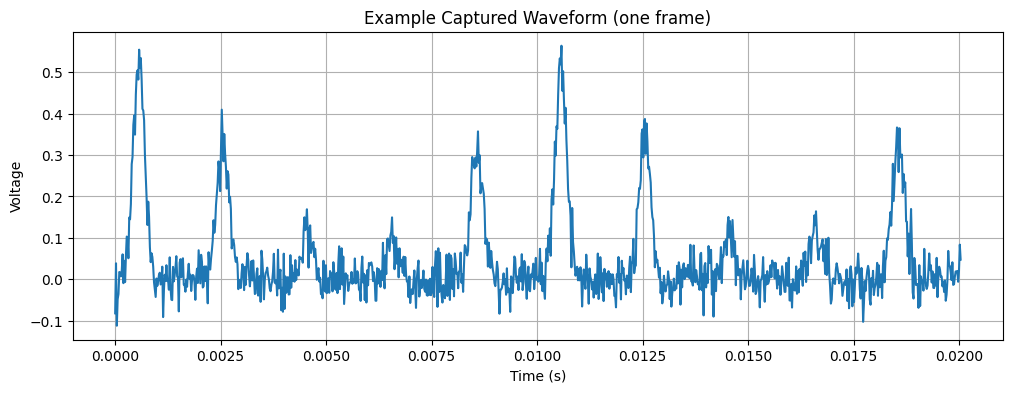

In [14]:
# Compute and display the sampling rate based on captured data
sampling_rate = osc.get_samplerate()
print("Sampling rate:", format_sampling_rate(osc.get_samplerate()["sample_rate"]))

# Plot an example frame of the captured data
plt.figure(figsize=(12, 4))
plt.plot(data["time"], data["ch1"])
plt.title("Example Captured Waveform (one frame)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()


# 3. Training the model

In [7]:
# Read the saved frames from CSV, and shuffle it
data = load_data_from_csv(output_filename)
np.random.shuffle(data) 

In [8]:
# Split into training and testing datasets (80% train, 20% test)
split_index = int(len(data) * 0.8)
full_training_dataset = data[:split_index]
full_testing_dataset = data[split_index:]

print(f"N. of frames in the training dataset: {len(full_training_dataset)}")
print(f"N. of frames in the testing dataset: {len(full_testing_dataset)}")

N. of frames in the training dataset: 1320
N. of frames in the testing dataset: 330


We define our model and create an early stopping configuration for faster trianing process.

In [9]:
quant_mod = LinnModel()
early_stopping_config = {
    'patience': 50,            # allow 50 epochs without improvement
    'restore_best_weights': True,
    'monitor':"val_loss"
}

In [10]:
frame_length = len(full_training_dataset[0])
print(f"Frame length: {frame_length}")

# Configure the model inputs/outputs (autoencoder: outputs = inputs)
quant_mod.set_training_data(training_inputs=full_training_dataset,
                             training_outputs=full_training_dataset,
                             scale=False)

# Define a simple autoencoder architecture: 
#  - encoder layers with 16,16 neurons (relu and tanh activation)
#  - final decoder layer with 'frame_length' neurons (linear activation)
# You may wish to change the model structure depending on the waveform type to
# improve model performance
model_definition = [    
    (16, 'relu'),
    (16, 'tanh'),
    (frame_length, 'linear')]


# Build the model and specify a learning rate
quant_mod.construct_model(model_definition, show_summary=True)
quant_mod.model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

Frame length: 100


2025-11-17 14:12:12.919995: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer               │ (None, 16)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_1             │ (None, 16)             │             0 │
│ (OutputClipLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clip_layer_2             │ (None, 100)            │             0 │
│ (OutputClipLayer)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,588 (14.02 KB)

 Trainable params: 3,588 (14.02 KB)

 Non-trainable params: 0 (0.00 B)

We can now train our model.

In [11]:
history = quant_mod.fit_model(
    epochs=450,
    es_config=early_stopping_config,
    validation_split=0.1,
    verbose=1
)


Value for restore missing. Using default:False.


Epoch 1/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0118 - val_loss: 0.0098
Epoch 2/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 3/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 4/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 5/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 6/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 12/450
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

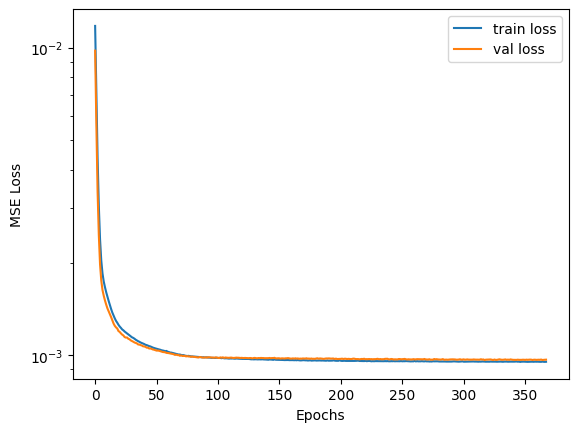

In [12]:
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

# 4. Saving the model

After training is complete, we can save the model to our current working directory.

In [13]:
model_filename = f"AD_{waveName}_model_Large_Noisy_{timestamp}.linn"
# Create a time-base array for mapping (same length as frame)
T = np.linspace(-1, 1, frame_length)
# Save the trained model to file
save_linn(quant_mod, input_channels=1, output_channels=1,
          file_name=model_filename, output_mapping=[T.size-1])

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 141 cycles


# 5. Evaluate model reconstruction performance

Before moving to anomaly detection, we first evaluate the model's performance on reconstructing the original signal for the testing dataset

In [17]:
full_testing_dataset_np = np.array(full_testing_dataset)
reconstructions_test = quant_mod.predict(full_testing_dataset_np)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


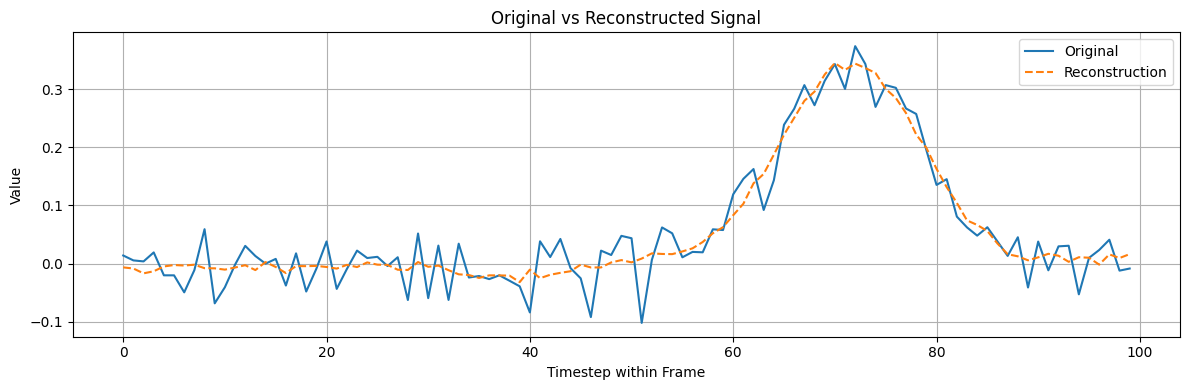

In [18]:
frame_id = 2 # for example, take the third testing frame
plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset[frame_id], label='Original')
plt.plot(reconstructions_test[frame_id], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Timestep within Frame')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
original = np.array(full_testing_dataset_np)
reconstructed = np.array(reconstructions_test)

# --- Error calculations ---
# Absolute error for each sample
absolute_error = np.abs(original - reconstructed)
# Squared error for each sample
squared_error = (original - reconstructed) ** 2

# Summed error per frame (could be used as an anomaly score per frame)
absolute_error_per_frame = absolute_error.sum(axis=1)
squared_error_per_frame = squared_error.sum(axis=1)

Get the MSE of the testing dataset

In [20]:
print(f"{"MSE: "}{np.mean(squared_error_per_frame)}")

MSE: 0.09788388571490293


# 6. Artificial anomaly detection

Now we are going to test the model's performance on detecting artificially inserted anomalies.

To do this, we insert random anomalous data points into frames 52-57 of the testing data set, at index 3-8 of each of those frames, replacing the original data points.

Then we run the model prediction on this new dataset.

In [21]:
full_testing_dataset_npAnom = full_testing_dataset_np.copy()
for i in range(52, 58):
    a = np.random.rand(5) * 0.5
    full_testing_dataset_npAnom[i,3:8] = a
reconstructions_test_anom = quant_mod.predict(full_testing_dataset_npAnom)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


We can now compare how the model reconstructs the signal with and without anomalies for same data frame.

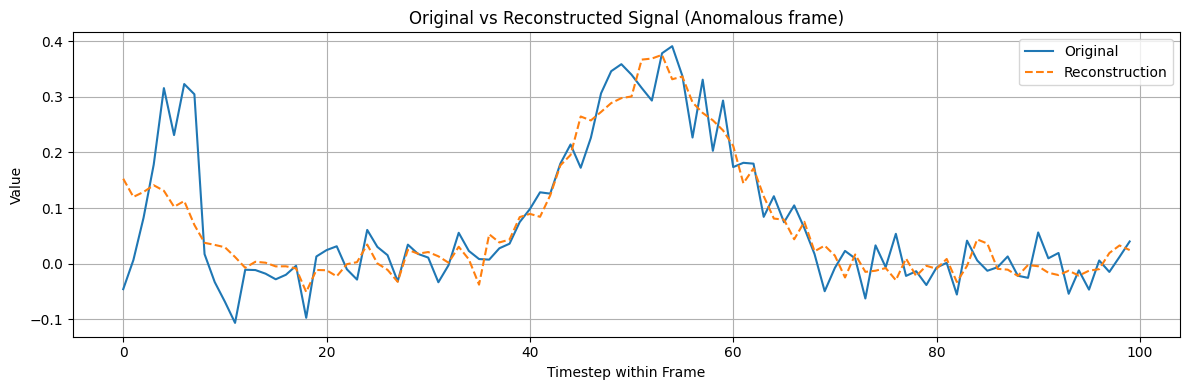

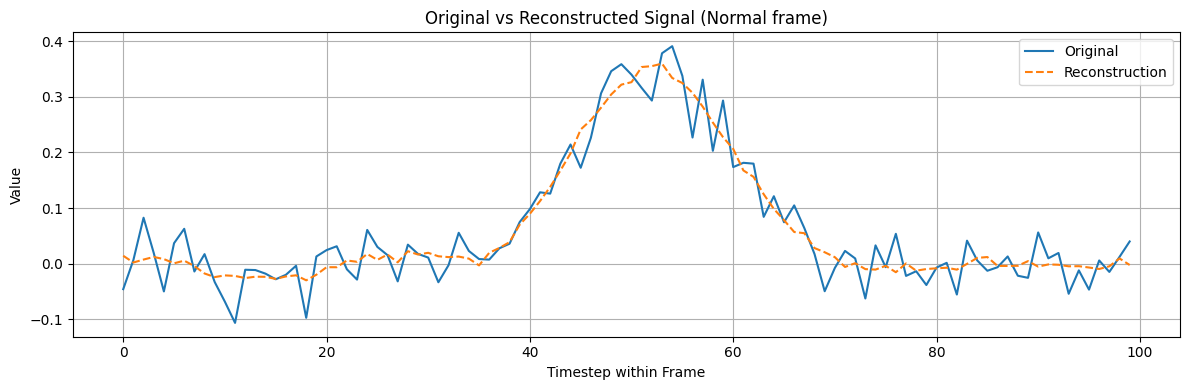

In [22]:
# Take any frame within 52-57 range with the anomaly
example_frame_id = 55

# Plot original vs reconstructed for the anomalous frame
plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset_npAnom[example_frame_id], label='Original')
plt.plot(reconstructions_test_anom[example_frame_id], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal (Anomalous frame)')
plt.xlabel('Timestep within Frame')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot original vs reconstructed for the same frame without the artifical anomaly
plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset_np[example_frame_id], label='Original')
plt.plot(reconstructions_test[example_frame_id], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal (Normal frame)')
plt.xlabel('Timestep within Frame')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Anomaly detection on Moku device

To see the model's anomaly detection performance on a Moku device, we can deploy it into a multi-instrument context, with the following configuration.

<center>
<figure>
<img src="Screenshots/ADN_MIM.png" alt="MIM" width="600">
<figcaption>Multi-Instrument Config</figcaption>
</figure> 
</center>

<center>
<figure>
<img src="Screenshots/ADN_AWG.png" alt="AWG" width="600">
<figcaption>Arbitrary Wave Generator Config</figcaption>
</figure> 
</center>

<center>
<figure>
<img src="Screenshots/ADN_AWG2.png" alt="AWG_Func" width="600">
<figcaption>Generator Function with Anomaly</figcaption>
</figure> 
</center>

<center>
<figure>
<img src="Screenshots/ADN_PID.png" alt="PID" width="600">
<figcaption>PID Config</figcaption>
</figure> 
</center>

<center>
<figure>
<img src="Screenshots/ADN_NN.png" alt="NN" width="600">
<figcaption>Loaded Neural Network Model</figcaption>
</figure> 
</center>

<center>
<figure>
<img src="Screenshots/ADN_OSC.png" alt="OSC" width="600">
<figcaption>Oscilloscope with Math function</figcaption>
</figure> 
</center>

We can now directly perform analysis on the recorded waveform data from the oscilloscope. Here is a guide on how to gather the data yourself. 

https://knowledge.liquidinstruments.com/en_US/data-logger/how-do-i-export-measured-data-from-my-moku

We also have provided a sample data.

In [6]:
dataPath = "CustomWaveSquaredErrors_20251028_130356_Traces.csv"

# Skip text configuration lines to go directly to data
numberOfHeaderLines = 12

We read the data into python lists.

In [7]:
# Arbitrary time (x-axis)
time = []
# Neural net output
neuralNet = []
# Original wave + anomaly
noisyWave = []
# Math function output
originalSquaredError = []

with open(dataPath, mode ='r')as file:
    csvFile = csv.reader(file)
    for i in range (numberOfHeaderLines):    
        next(csvFile)
    for lines in csvFile:
        time.append(float(lines[0]))
        neuralNet.append(float(lines[1]))
        noisyWave.append(float(lines[2]))
        originalSquaredError.append(float(lines[3]))

time = np.array(time)
neuralNet = np.array(neuralNet)
noisyWave = np.array(noisyWave)
originalSquaredError = np.array(originalSquaredError)

Sometimes the neural network output is delayed by a few cycles and causes a phase shift in the neural network output data, which interferes with evaluating the model's anomaly detection performance metrics. So we can adjust for the phase shift here in python.

In [8]:
# Adjust phase shift using this value
phaseShiftAmount = -3

neuralNet =  shift(neuralNet, phaseShiftAmount, cval=0)

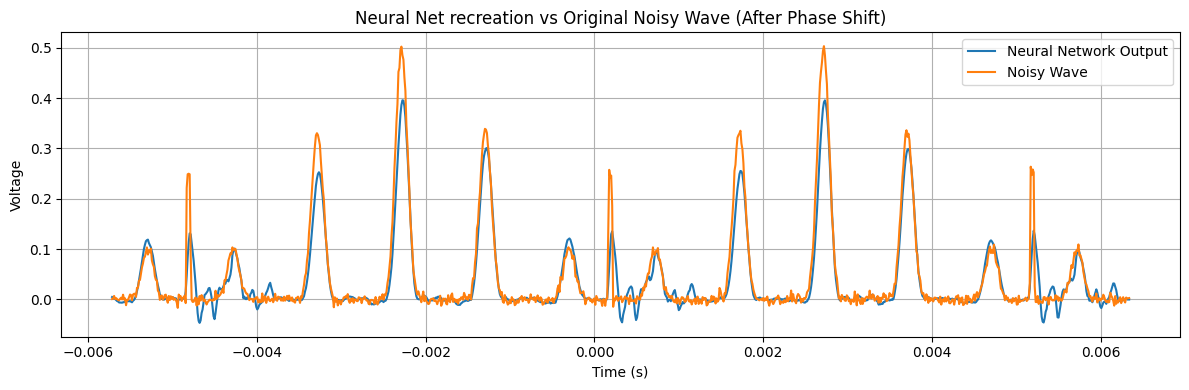

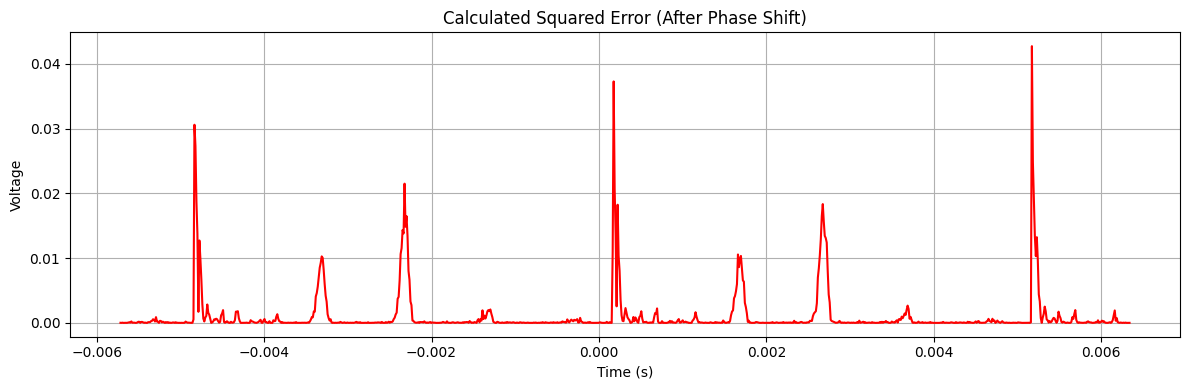

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(time, neuralNet, label = "Neural Network Output")
plt.plot(time, noisyWave, label = "Noisy Wave")
plt.title("Neural Net recreation vs Original Noisy Wave (After Phase Shift)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.title("Calculated Squared Error (After Phase Shift)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.plot(time, (neuralNet - noisyWave)**2, label = "SE", color='red')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
print(f"{"MSE: "}{np.mean((neuralNet - noisyWave)**2)}")

MSE: 0.001026455366979165


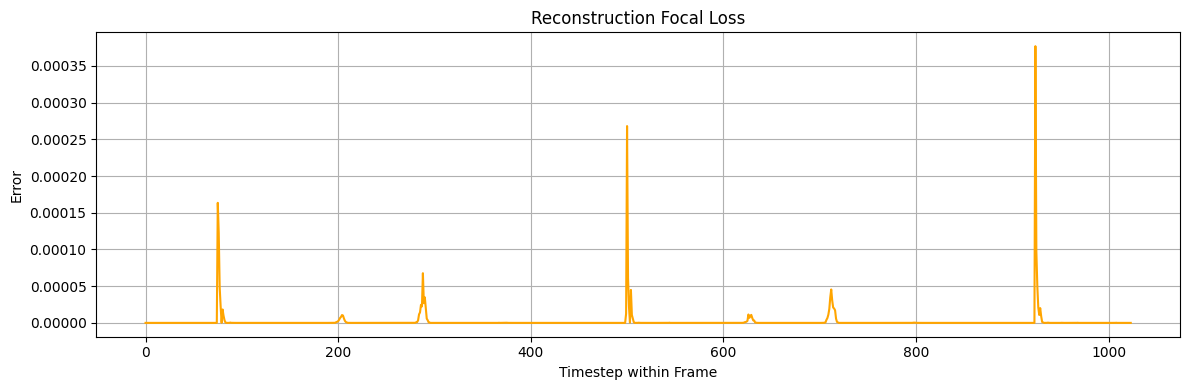

In [13]:
# Compute focal loss
focal_loss = focal_mse_loss(neuralNet, noisyWave)

plt.figure(figsize=(12, 4))
plt.plot(focal_loss, label='Frame with anomaly', color='orange')
plt.title('Reconstruction Focal Loss')
plt.xlabel('Timestep within Frame')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional Information

You may choose to continue experimenting on anomaly detection on other waveforms, as we have provided additional instrument configuration files for Sinc, Gaussian and ExponentialFall Wave types. 

To change the waveform, simply change the `waveName` variable at the start of Section 2 to one of the stated waves, or you may wish to create your own.